In [3]:
# -*- coding: utf-8 -*-
import dataiku
import pandas as pd, numpy as np
from dataiku import pandasutils as pdu

from datetime import date, datetime, timedelta
import time

import matplotlib.pyplot as plt

t0 = time.time()

"NAFCUSTOMER_REVENUE_AGGREGATED_2022"

# Read recipe inputs
NAFCUSTOMER_REVENUE_AGGREGATED_2019 = dataiku.Dataset("NAFCUSTOMER_REVENUE_AGGREGATED_2019")
NAFCUSTOMER_REVENUE_AGGREGATED_2019_df = NAFCUSTOMER_REVENUE_AGGREGATED_2019.get_dataframe()
print('loaded file 2019')

NAFCUSTOMER_REVENUE_AGGREGATED_2020 = dataiku.Dataset("NAFCUSTOMER_REVENUE_AGGREGATED_2020")
NAFCUSTOMER_REVENUE_AGGREGATED_2020_df = NAFCUSTOMER_REVENUE_AGGREGATED_2020.get_dataframe()
print('loaded file 2020')

NAFCUSTOMER_REVENUE_AGGREGATED_2021 = dataiku.Dataset("NAFCUSTOMER_REVENUE_AGGREGATED_2021")
NAFCUSTOMER_REVENUE_AGGREGATED_2021_df = NAFCUSTOMER_REVENUE_AGGREGATED_2021.get_dataframe()
print('loaded file 2021')

NAFCUSTOMER_REVENUE_AGGREGATED_2022 = dataiku.Dataset("NAFCUSTOMER_REVENUE_AGGREGATED_2022")
NAFCUSTOMER_REVENUE_AGGREGATED_2022_df = NAFCUSTOMER_REVENUE_AGGREGATED_2022.get_dataframe()
print('loaded file 2022')

NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT = dataiku.Dataset("NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT")
NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT_df = NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT.get_dataframe()

print('loaded annual card count')

t1 = time.time()
print("load duration", (t1-t0)/60.0, "minutes")

loaded file 2019
loaded file 2020
loaded file 2021
loaded file 2022
loaded annual card count
load duration 16.576754001776376 minutes


In [5]:
# create a copy of the input datasets
# this leaves the original dataset in memory and allows for a quick reload without having to back to Snowflake

print(len(NAFCUSTOMER_REVENUE_AGGREGATED_2019_df))
print(len(NAFCUSTOMER_REVENUE_AGGREGATED_2020_df))
print(len(NAFCUSTOMER_REVENUE_AGGREGATED_2021_df))
print(len(NAFCUSTOMER_REVENUE_AGGREGATED_2022_df))

df = pd.concat([NAFCUSTOMER_REVENUE_AGGREGATED_2019_df,NAFCUSTOMER_REVENUE_AGGREGATED_2020_df,
               NAFCUSTOMER_REVENUE_AGGREGATED_2021_df,NAFCUSTOMER_REVENUE_AGGREGATED_2022_df])
print(len(df))

print(len(NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT_df), "rows in NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT")
df_a = NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT_df

13270961
14637226
16086987
17581752
61576926
2319568 rows in NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT


In [30]:
df.head()

,CUSTOMER_ID,CUSTOMER,REVENUE_YEAR,REVENUE_MONTH,REVENUE_CODE_GROUP,REVENUE_CATEGORY,SETUP_DATE,REVENUE_AMOUNT_USD,GROSS_SPEND_AMOUNT,PURCHASE_GALLONS_QTY,TOTAL_ACTIVE_CARD_COUNT,SETUP_DATE_DT,SETUP_YEAR,REVENUE_DATE
0,77330968,KC BOBCAT,2019,6,Interchange,Payment Processing Revenue,2013-03-14 07:00:00+00:00,9.16,980.74,268.7665,0.0,2013-03-14 07:00:00+00:00,2013,06-2019
1,77354366,LEGACY MILLWORK INC,2019,5,Late Fees,Finance Fee Revenue,2015-01-16 08:00:00+00:00,0.00,NaN,NaN,0.0,2015-01-16 08:00:00+00:00,2015,05-2019
2,77472247,PROFESSIONAL LAWN MAINTENANCE,2019,7,Fees,Account Servicing Net Revenue,2006-03-23 08:00:00+00:00,0.00,NaN,NaN,0.0,2006-03-23 08:00:00+00:00,2006,07-2019
3,77621189,VILLAGE OF CONSORT,2019,5,Fees,Account Servicing Net Revenue,2014-08-13 07:00:00+00:00,0.00,NaN,NaN,0.0,2014-08-13 07:00:00+00:00,2014,05-2019
4,77344982,L318 CANADIAN SCALE COMPANY LI,2019,3,Late Fees,Finance Fee Revenue,2015-04-14 07:00:00+00:00,0.00,NaN,NaN,0.0,2015-04-14 07:00:00+00:00,2015,03-2019


In [8]:
# Prep data
#
# cast year to integer and create a revenue date column using month and year
#

df['CUSTOMER_ID'] = df['CUSTOMER_ID'].astype('Int64')
df['SETUP_DATE_DT'] = pd.to_datetime(df['SETUP_DATE'])
df['SETUP_YEAR'] = df.SETUP_DATE_DT.dt.year

df['REVENUE_YEAR'] = df['REVENUE_YEAR'].astype('Int64')
df['REVENUE_DATE'] = df['REVENUE_MONTH'].astype(str) + '-' + df['REVENUE_YEAR'].astype(str)
df['REVENUE_DATE'] = pd.to_datetime(df['REVENUE_DATE'], format='%m-%Y').dt.strftime('%m-%Y')

#
# filter out Jan 2023 as it represents only a partial year
#

print(len(df), "before filter")
df = df[df.REVENUE_YEAR!=2023]
print(len(df), "after filter, removing 2023")

# break down of revenue_year
df.REVENUE_YEAR.value_counts()

61576926 before filter
61576926 after filter, removing 2023


2022    17581752
2021    16086987
2020    14637226
2019    13270961
Name: REVENUE_YEAR, dtype: Int64

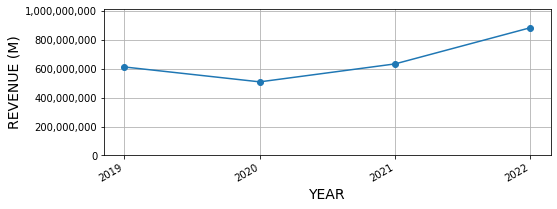

,REVENUE_YEAR,REVENUE_AMOUNT_USD
0,2019,6.118864e+08
1,2020,5.089365e+08
2,2021,6.331536e+08
3,2022,8.832951e+08


In [9]:
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt

# plot out sum of revenue per year
# in order to do a quick reonciliation against

# aggregate revenue at annual grain
df_revenue_per_year = df.groupby(['REVENUE_YEAR']).REVENUE_AMOUNT_USD.sum().reset_index()
df_revenue_per_year.REVENUE_AMOUNT_USD = df_revenue_per_year.REVENUE_AMOUNT_USD
df_revenue_per_year.head()

max_revenue = df_revenue_per_year.REVENUE_AMOUNT_USD.max()

chart_revenue_year = []
for y in df_revenue_per_year.REVENUE_YEAR.tolist():
    chart_revenue_year.append(str(y))

fig, ax1 = plt.subplots(figsize=(8,3))
ax1.plot(chart_revenue_year,df_revenue_per_year['REVENUE_AMOUNT_USD'], marker='o')
ax1.set_xlabel('YEAR', fontsize=14)
ax1.set_ylabel('REVENUE (M)', fontsize=14)
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.grid()
ax1.set_ylim(ymin=0, ymax=max_revenue*1.15)
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
fig.autofmt_xdate()
plt.show()

df_revenue_per_year.head()

In [10]:
df_revenue_by_customer_and_year = df.groupby(['CUSTOMER_ID','CUSTOMER','REVENUE_YEAR']).REVENUE_AMOUNT_USD.sum().reset_index()
print(len(df_revenue_by_customer_and_year))

df_spend_by_customer_and_year = df.groupby(['CUSTOMER_ID','CUSTOMER','REVENUE_YEAR']).GROSS_SPEND_AMOUNT.sum().reset_index()
print(len(df_spend_by_customer_and_year))

df_active_card_count_by_customer = df_a.groupby(['CUSTOMER_ID','CUSTOMER','YEAR_NUMBER']).ACTIVE_CARD_COUNT.sum().reset_index()
df_active_card_count_by_customer.columns = ['CUSTOMER_ID','CUSTOMER','REVENUE_YEAR','ACTIVE_CARD_COUNT']
print(len(df_active_card_count_by_customer))

df_customer_setup_year = df.groupby(['CUSTOMER_ID','CUSTOMER']).SETUP_YEAR.min().reset_index()
print(len(df_customer_setup_year))

df_customer_fleet_size = df_active_card_count_by_customer.groupby(['CUSTOMER_ID','CUSTOMER']).ACTIVE_CARD_COUNT.max().reset_index()
df_customer_fleet_size.columns = ['CUSTOMER_ID', 'CUSTOMER', 'FLEET_SIZE']

df_customer_fleet_size['FLEET_SIZE_CATEGORY'] = 'NOT SET'
df_customer_fleet_size.loc[df_customer_fleet_size.FLEET_SIZE<=0, 'FLEET_SIZE_CATEGORY'] = 'zero cards'
for i in range(1,21):
    df_customer_fleet_size.loc[df_customer_fleet_size.FLEET_SIZE==i, 'FLEET_SIZE_CATEGORY'] = str(i) + ' card(s)'
df_customer_fleet_size.loc[df_customer_fleet_size.FLEET_SIZE>20, 'FLEET_SIZE_CATEGORY'] = '> 20 cards'
print(len(df_customer_fleet_size))

1777729
1777729
1771976
650886
649448


In [26]:
df_revenue_by_customer_revenue_category_and_year = df.groupby(['CUSTOMER_ID','CUSTOMER','REVENUE_CATEGORY','REVENUE_YEAR']).REVENUE_AMOUNT_USD.sum().reset_index()
df_revenue_by_customer_revenue_category_and_year.head()

,CUSTOMER_ID,CUSTOMER,REVENUE_CATEGORY,REVENUE_YEAR,REVENUE_AMOUNT_USD
0,77000000,1 AUTO PARTS INC,Account Servicing Net Revenue,2019,0.00
1,77000000,1 AUTO PARTS INC,Finance Fee Revenue,2019,225.00
2,77000000,1 AUTO PARTS INC,Other Revenue,2019,-49.53
3,77000000,1 AUTO PARTS INC,Payment Processing Revenue,2019,0.00
4,77000001,94775 J AND J SNACK FOODS AA,Account Servicing Net Revenue,2022,0.00


In [29]:
df_revenue_by_customer_revenue_category_and_year[df_revenue_by_customer_revenue_category_and_year.CUSTOMER_ID==77060321].head(100)

,CUSTOMER_ID,CUSTOMER,REVENUE_CATEGORY,REVENUE_YEAR,REVENUE_AMOUNT_USD
546651,77060321,AT&T,Account Servicing Net Revenue,2019,6625.00
546652,77060321,AT&T,Account Servicing Net Revenue,2020,10747.50
546653,77060321,AT&T,Account Servicing Net Revenue,2021,11620.00
546654,77060321,AT&T,Account Servicing Net Revenue,2022,8653.75
546655,77060321,AT&T,Finance Fee Revenue,2019,0.00
546656,77060321,AT&T,Finance Fee Revenue,2020,0.00
546657,77060321,AT&T,Finance Fee Revenue,2021,0.00
546658,77060321,AT&T,Finance Fee Revenue,2022,0.00
546659,77060321,AT&T,Other Revenue,2020,43396.89
546660,77060321,AT&T,Other Revenue,2021,68200.00


In [11]:
print(len(df_revenue_by_customer_and_year))
df_j = pd.merge(df_revenue_by_customer_and_year,df_spend_by_customer_and_year,how='left',on=['CUSTOMER_ID','CUSTOMER','REVENUE_YEAR'])
print(len(df_j))

df_j = pd.merge(df_j,df_active_card_count_by_customer,how='left',on=['CUSTOMER_ID','CUSTOMER','REVENUE_YEAR'])
print(len(df_j))

df_j = pd.merge(df_j,df_customer_fleet_size, how='left',on=['CUSTOMER_ID','CUSTOMER'])
print(len(df_j))

df_j = pd.merge(df_j, df_customer_setup_year, how='left', on=['CUSTOMER_ID','CUSTOMER'])
print(len(df_j))

df_j.loc[df_j.ACTIVE_CARD_COUNT.isnull(),'ACTIVE_CARD_COUNT'] = 0
df_j.loc[df_j.FLEET_SIZE.isnull(),'FLEET_SIZE'] = 0

df_j['FLEET_SIZE_GROUP'] = 'NOT SET'
df_j.loc[df_j.FLEET_SIZE.between(0,5),'FLEET_SIZE_GROUP'] = '(<=5 cards)'
df_j.loc[df_j.FLEET_SIZE.between(6,100),'FLEET_SIZE_GROUP'] = '(between 6 and 100 cards)'
df_j.loc[df_j.FLEET_SIZE>100,'FLEET_SIZE_GROUP'] = '(>100 cards)'
df_j.head()

1777729
1777729
1777729
1777729
1777729


,CUSTOMER_ID,CUSTOMER,REVENUE_YEAR,REVENUE_AMOUNT_USD,GROSS_SPEND_AMOUNT,ACTIVE_CARD_COUNT,FLEET_SIZE,FLEET_SIZE_CATEGORY,SETUP_YEAR,FLEET_SIZE_GROUP
0,77000000,1 AUTO PARTS INC,2019,175.47,0.00,1.0,1.0,1 card(s),2012,(<=5 cards)
1,77000001,94775 J AND J SNACK FOODS AA,2022,74.15,3318.62,3.0,3.0,3 card(s),2022,(<=5 cards)
2,77000002,APOSTROPHE DESIGN INC,2019,177.47,8944.23,4.0,8.0,8 card(s),2018,(between 6 and 100 cards)
3,77000002,APOSTROPHE DESIGN INC,2020,271.60,10358.34,4.0,8.0,8 card(s),2018,(between 6 and 100 cards)
4,77000002,APOSTROPHE DESIGN INC,2021,243.51,13094.44,8.0,8.0,8 card(s),2018,(between 6 and 100 cards)


In [12]:
df_j.FLEET_SIZE_CATEGORY.unique()

array(['1 card(s)', '3 card(s)', '8 card(s)', '> 20 cards', '7 card(s)',
       '19 card(s)', '4 card(s)', '15 card(s)', '2 card(s)', '12 card(s)',
       '6 card(s)', '16 card(s)', '20 card(s)', '13 card(s)',
       '14 card(s)', '5 card(s)', '11 card(s)', '17 card(s)',
       '18 card(s)', '9 card(s)', '10 card(s)', nan], dtype=object)

1777729
1776264
----
Observed Average Retention Rate (2019-2022): 74.5 %
[0.543767840152236, 0.834107275052157, 0.857592383411328]


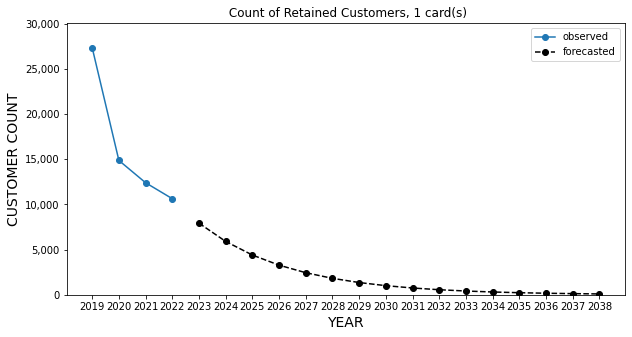

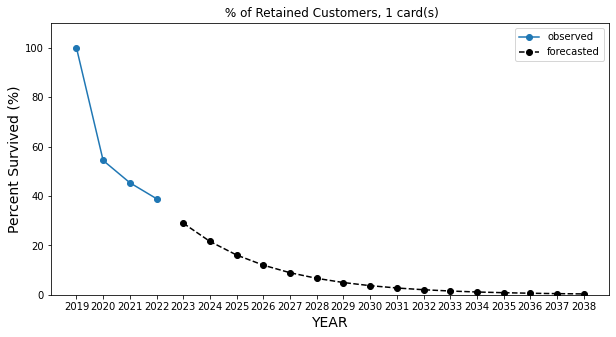

forecast period: 15
AVG Tenure (Observed + Forecasted): 3.46 Years
check_sum: 1.0
----
Observed Average Retention Rate (2019-2022): 75.5 %
[0.7138326121164438, 0.7428099059690697, 0.8086339608643235]


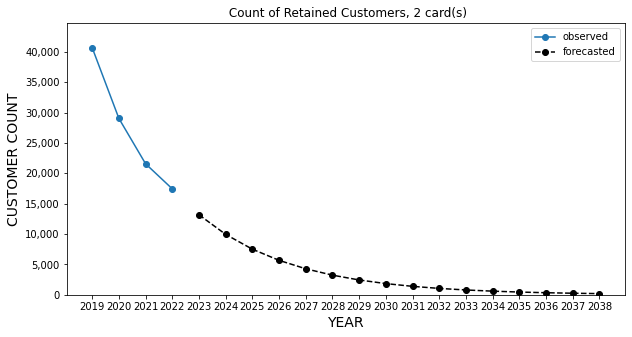

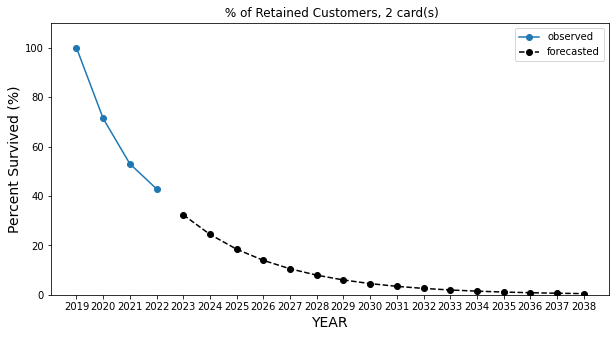

forecast period: 15
AVG Tenure (Observed + Forecasted): 3.92 Years
check_sum: 1.0
----
Observed Average Retention Rate (2019-2022): 84.7 %
[0.8463480191655954, 0.8298030985059789, 0.8659145367412141]


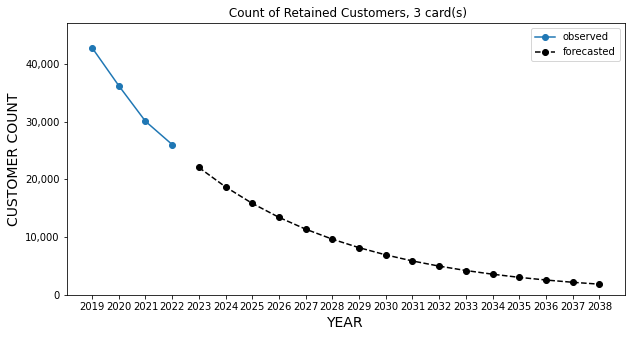

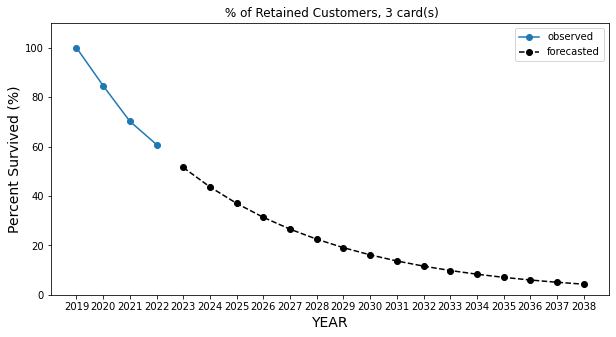

forecast period: 15
AVG Tenure (Observed + Forecasted): 5.89 Years
check_sum: 1.0
----
Observed Average Retention Rate (2019-2022): 89.7 %
[0.9039882257878333, 0.8819792498004788, 0.905603011437672]


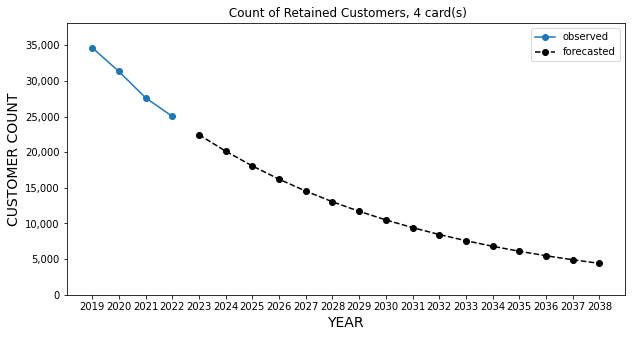

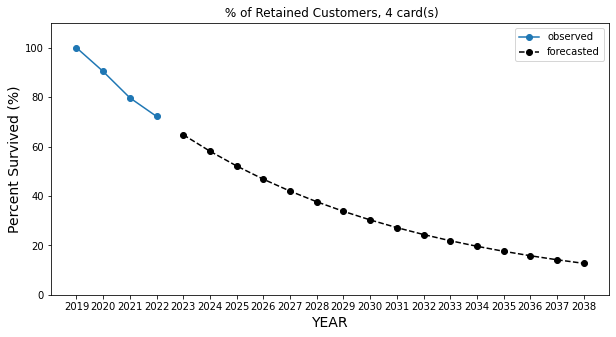

forecast period: 15
AVG Tenure (Observed + Forecasted): 7.59 Years
check_sum: 1.0
----
Observed Average Retention Rate (2019-2022): 92.10000000000001 %
[0.9298761439229667, 0.9086992608987787, 0.9246661737201514]


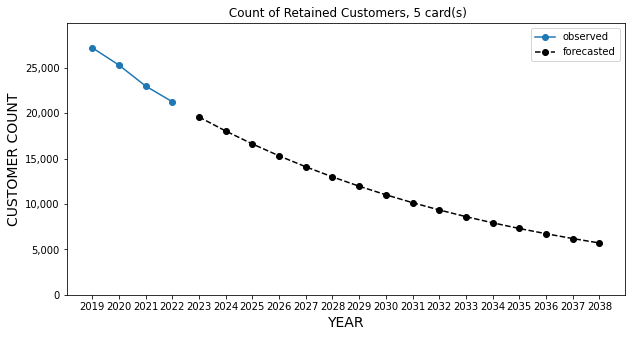

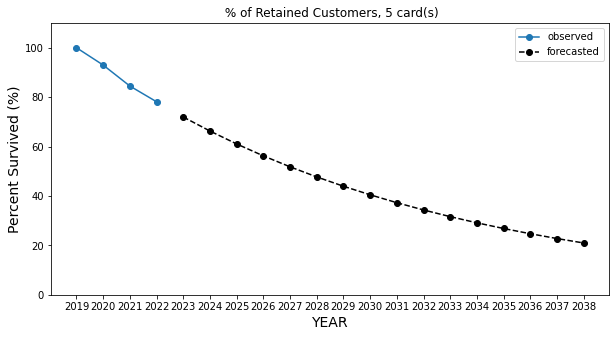

forecast period: 15
AVG Tenure (Observed + Forecasted): 8.67 Years
check_sum: 1.0
----
Observed Average Retention Rate (2019-2022): 93.60000000000001 %
[0.9461883408071748, 0.9304265402843602, 0.9327628361858191]


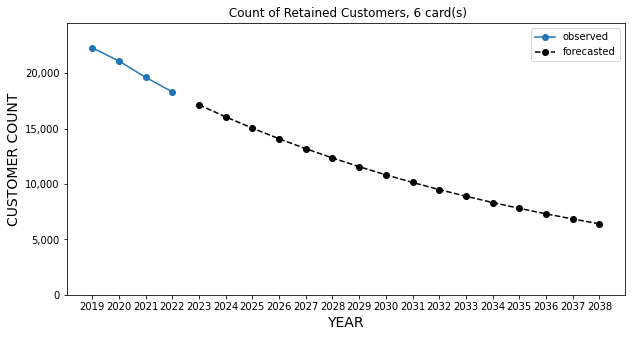

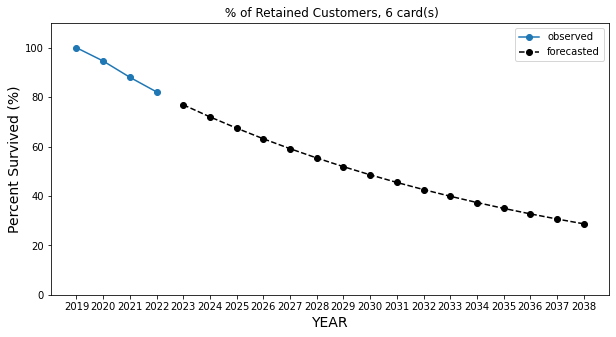

forecast period: 15
AVG Tenure (Observed + Forecasted): 9.47 Years
check_sum: 1.0
----
Observed Average Retention Rate (2019-2022): 94.39999999999999 %
[0.9512907103199588, 0.9388688327316486, 0.9405921558574725]


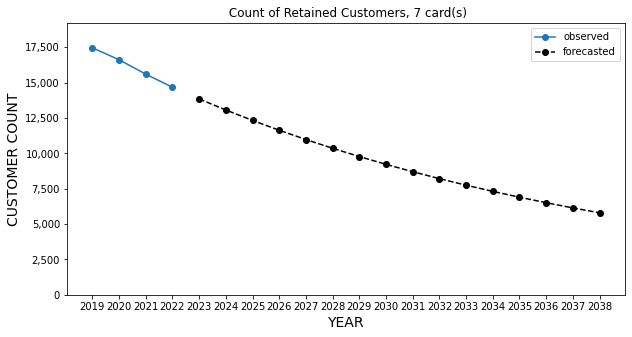

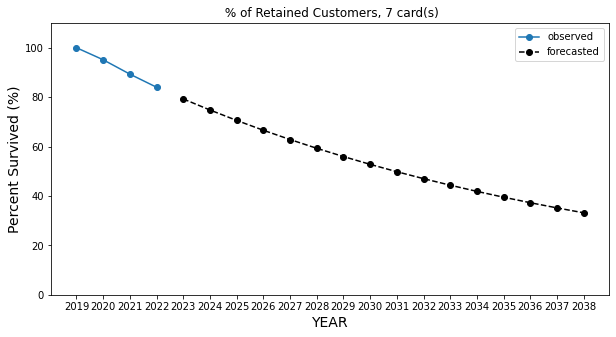

forecast period: 15
AVG Tenure (Observed + Forecasted): 9.87 Years
check_sum: 1.0
----
Observed Average Retention Rate (2019-2022): 95.1 %
[0.9597993266882302, 0.9465612104539202, 0.9479764586209402]


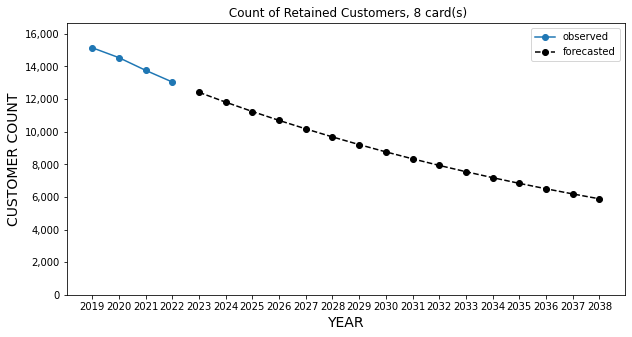

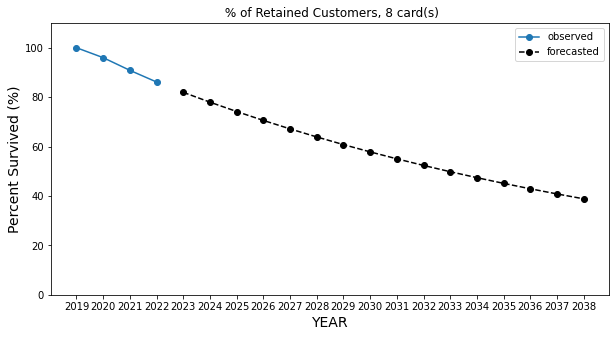

forecast period: 15
AVG Tenure (Observed + Forecasted): 10.35 Years
check_sum: 1.0
----
Observed Average Retention Rate (2019-2022): 95.5 %
[0.9627518995705319, 0.9494724200051471, 0.9533791109504879]


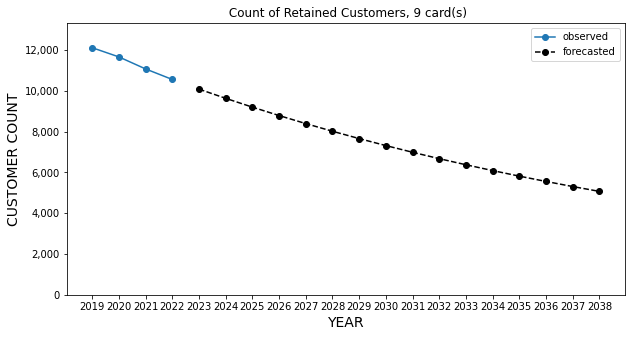

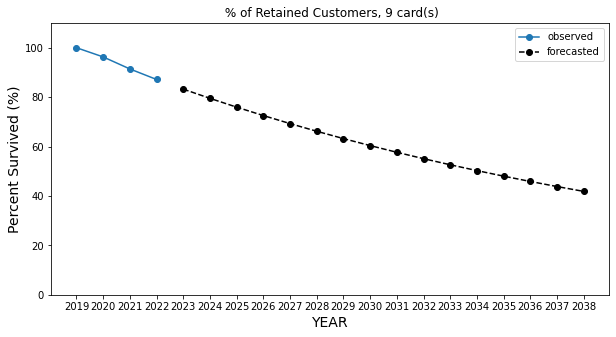

forecast period: 15
AVG Tenure (Observed + Forecasted): 10.58 Years
check_sum: 1.0
----
Observed Average Retention Rate (2019-2022): 95.89999999999999 %
[0.9634146341463414, 0.9555512609914001, 0.958640914147032]


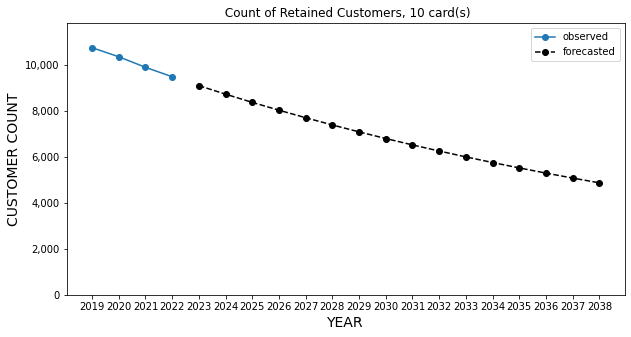

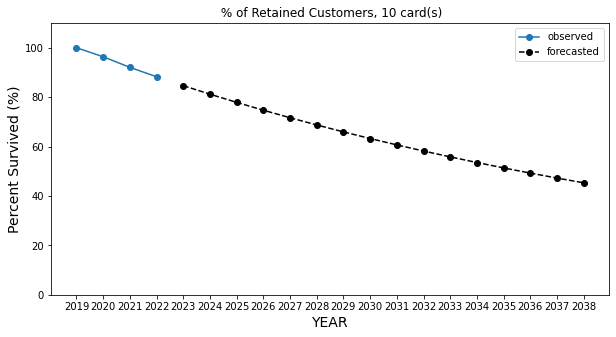

forecast period: 15
AVG Tenure (Observed + Forecasted): 10.84 Years
check_sum: 1.0
----
Observed Average Retention Rate (2019-2022): 96.3 %
[0.9670883241912012, 0.9555504109271906, 0.9649909145972138]


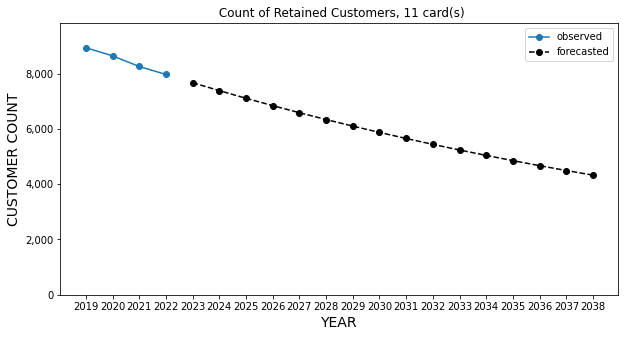

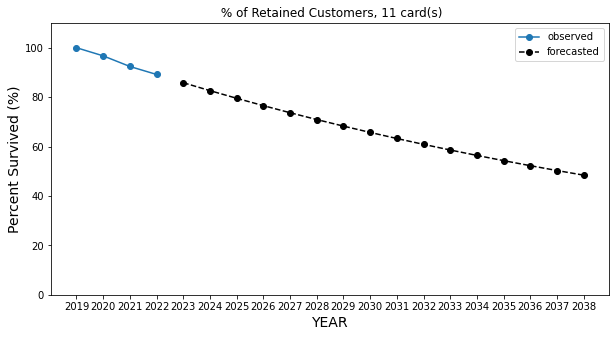

forecast period: 15
AVG Tenure (Observed + Forecasted): 11.06 Years
check_sum: 1.0
----
Observed Average Retention Rate (2019-2022): 96.39999999999999 %
[0.9714604789676139, 0.9581044833312045, 0.9632049060125316]


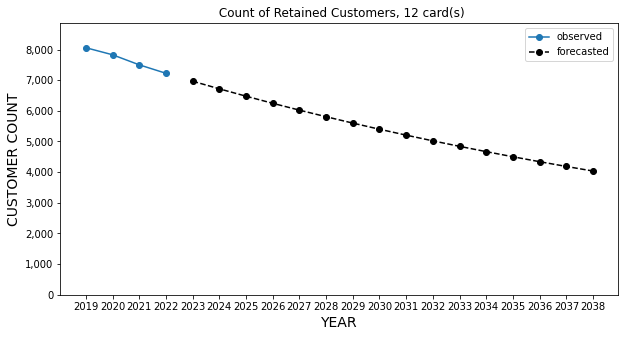

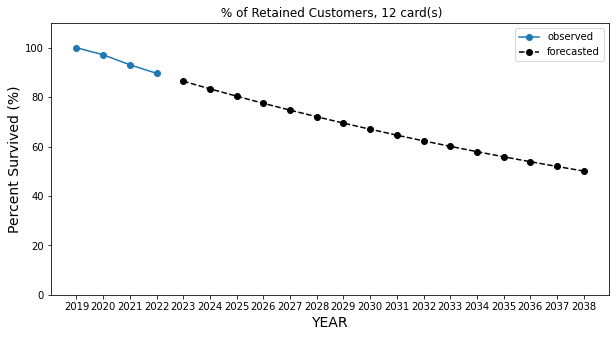

forecast period: 15
AVG Tenure (Observed + Forecasted): 11.18 Years
check_sum: 1.0
----
Observed Average Retention Rate (2019-2022): 96.6 %
[0.9715120525931337, 0.9589473684210527, 0.9661282734828289]


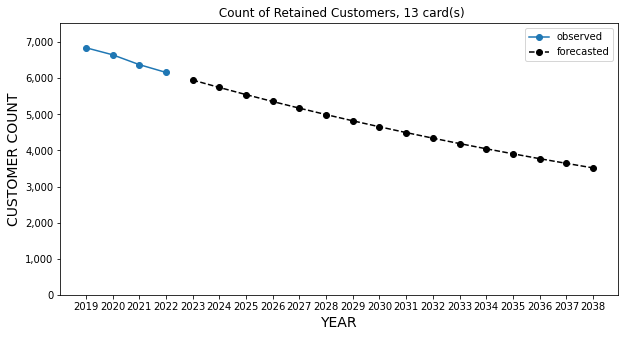

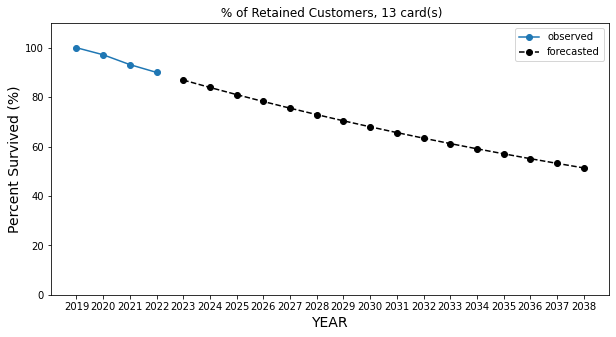

forecast period: 15
AVG Tenure (Observed + Forecasted): 11.26 Years
check_sum: 1.0
----
Observed Average Retention Rate (2019-2022): 96.6 %
[0.9687034277198212, 0.9627350427350427, 0.9675071022727273]


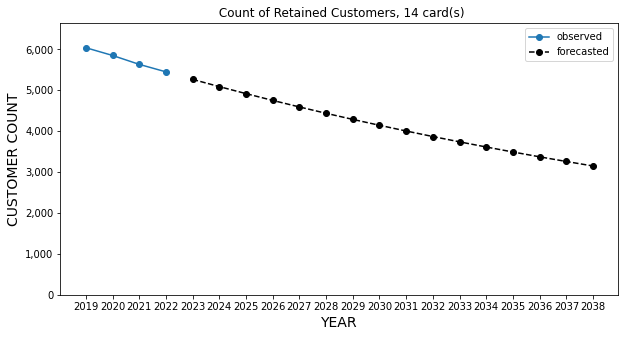

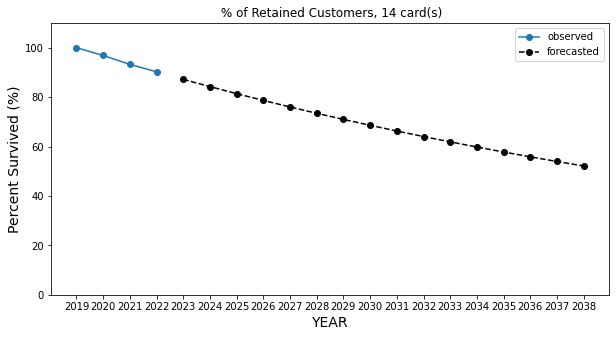

forecast period: 15
AVG Tenure (Observed + Forecasted): 11.31 Years
check_sum: 1.0
----
Observed Average Retention Rate (2019-2022): 96.5 %
[0.971174308376862, 0.9589641434262948, 0.9653095139177399]


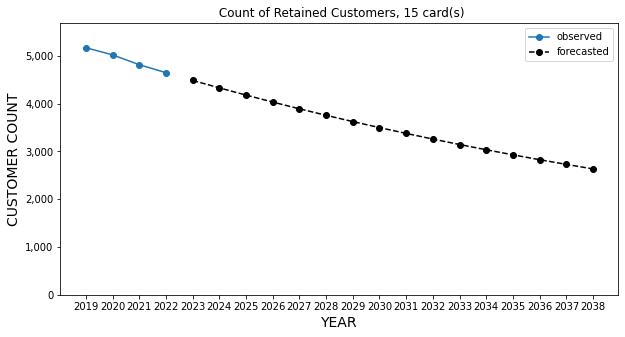

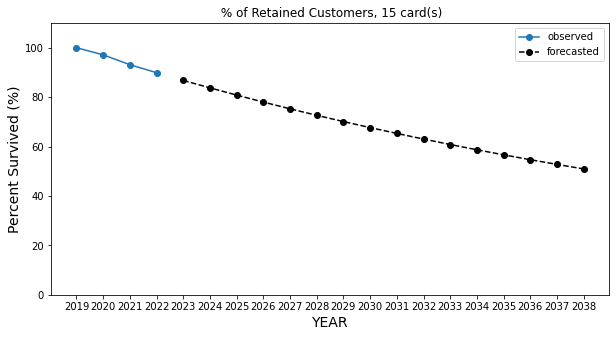

forecast period: 15
AVG Tenure (Observed + Forecasted): 11.24 Years
check_sum: 1.0
----
Observed Average Retention Rate (2019-2022): 96.5 %
[0.9727409315303713, 0.9598411297440423, 0.9629885057471265]


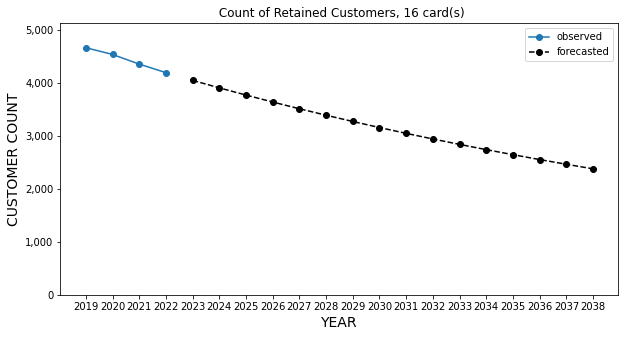

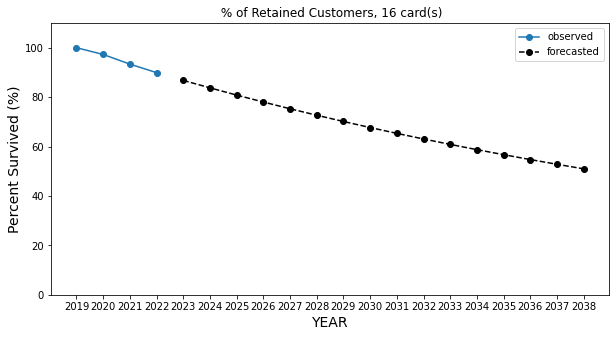

forecast period: 15
AVG Tenure (Observed + Forecasted): 11.24 Years
check_sum: 1.0
----
Observed Average Retention Rate (2019-2022): 97.0 %
[0.9746445497630332, 0.9645027960126429, 0.9715149987396017]


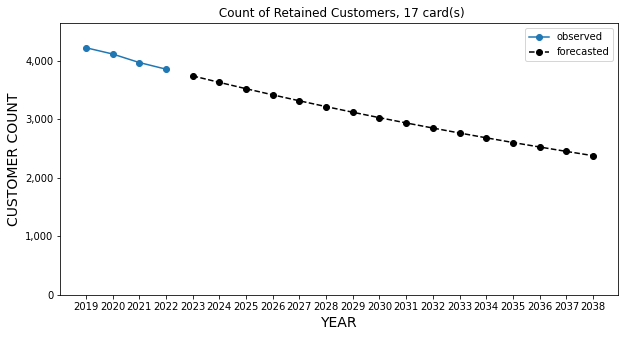

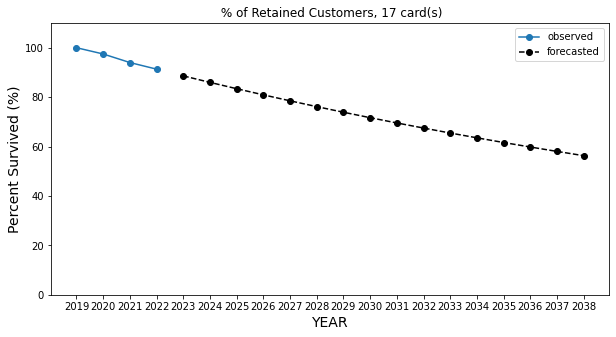

forecast period: 15
AVG Tenure (Observed + Forecasted): 11.59 Years
check_sum: 1.0
----
Observed Average Retention Rate (2019-2022): 96.8 %
[0.9713690786048933, 0.9627545551982851, 0.9707765098803228]


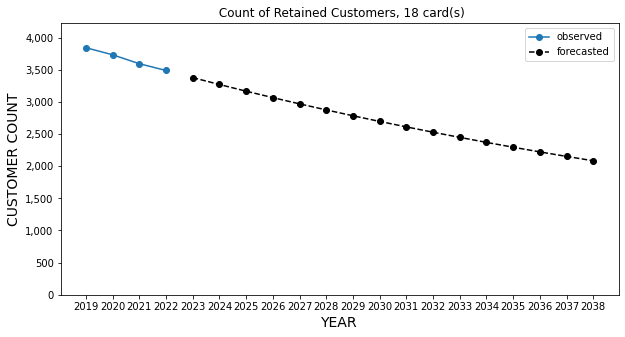

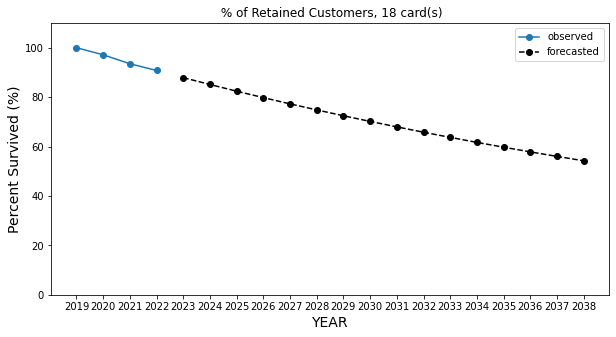

forecast period: 15
AVG Tenure (Observed + Forecasted): 11.45 Years
check_sum: 1.0
----
Observed Average Retention Rate (2019-2022): 96.8 %
[0.9722560975609756, 0.9623706491063029, 0.9683936135549038]


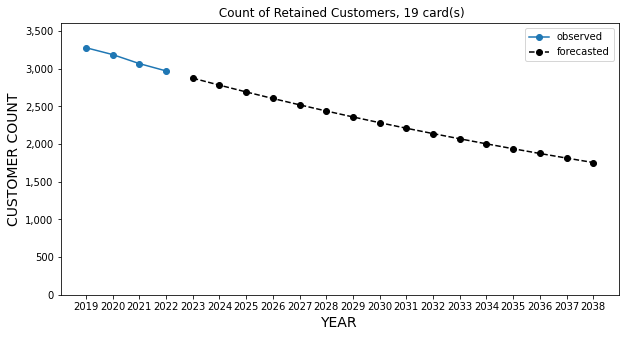

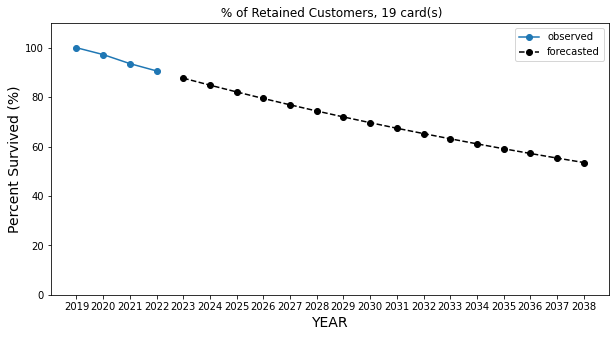

forecast period: 15
AVG Tenure (Observed + Forecasted): 11.41 Years
check_sum: 1.0
----
Observed Average Retention Rate (2019-2022): 96.89999999999999 %
[0.9746670997076973, 0.9623458847050983, 0.9702216066481995]


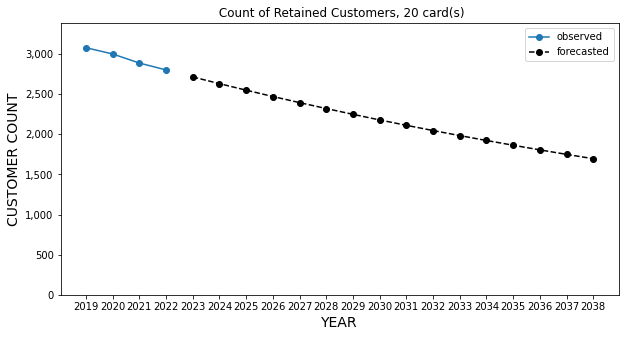

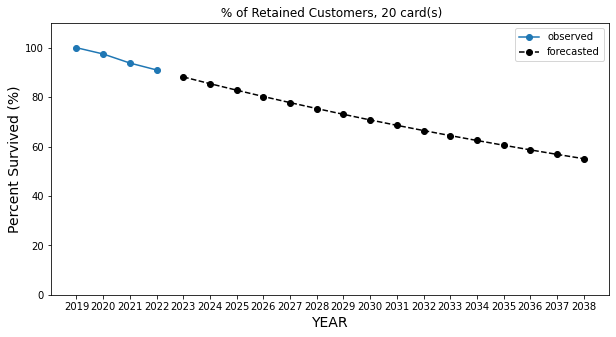

forecast period: 15
AVG Tenure (Observed + Forecasted): 11.51 Years
check_sum: 1.0
----
Observed Average Retention Rate (2019-2022): 97.0 %
[0.9757675308621069, 0.9673215091458124, 0.9680116256122284]


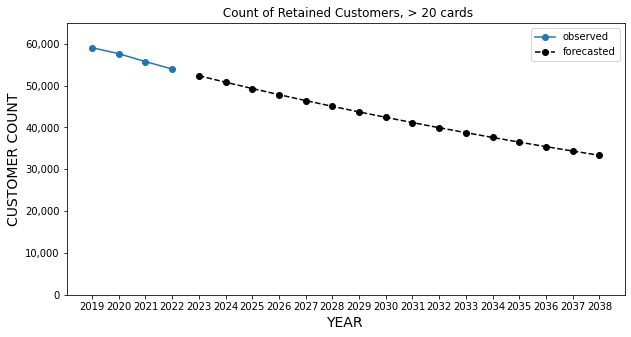

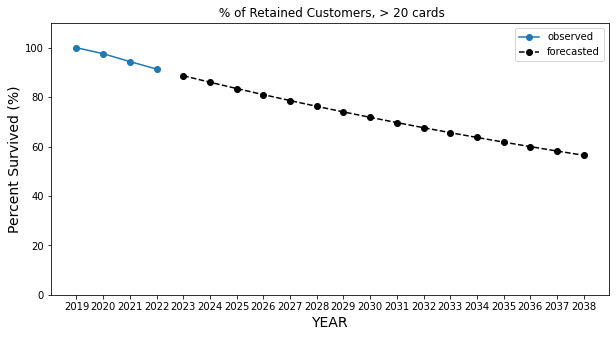

forecast period: 15
AVG Tenure (Observed + Forecasted): 11.61 Years
check_sum: 1.0


In [13]:
df_activity = df_j.copy()
print(len(df_activity))
df_activity = df_activity[~df_activity.FLEET_SIZE_CATEGORY.isnull()]
print(len(df_activity))

_fleet_size = []
_observed_avg_retention_rate = []
_expected_tenure = []
_revenue_year = []
_observed_customer_count = []
_observed_customer_percent = []
_chart_forecast_year = []
_chart_forecast_from_first = []

groups =  ['1 card(s)', '2 card(s)', '3 card(s)', '4 card(s)', '5 card(s)', '6 card(s)',
           '7 card(s)','8 card(s)','9 card(s)','10 card(s)',  '11 card(s)',
           '12 card(s)','13 card(s)','14 card(s)', '15 card(s)','16 card(s)','17 card(s)'
           ,'18 card(s)','19 card(s)','20 card(s)','> 20 cards']

for granular_filter_group in groups:

    df_sub = df_activity[df_activity.SETUP_YEAR<2019]
    df_sub = df_sub[df_sub.FLEET_SIZE_CATEGORY==granular_filter_group]

    df_sub = df_sub.groupby(['REVENUE_YEAR']).CUSTOMER_ID.nunique().reset_index()
    df_sub.columns = ['REVENUE_YEAR','CUSTOMER_COUNT']
    df_sub.REVENUE_YEAR = df_sub.REVENUE_YEAR.astype(str)
    df_sub.CUSTOMER_COUNT = df_sub.CUSTOMER_COUNT.astype('Int64')

    df_sub['SURVIVED_FROM_FIRST'] = (df_sub.CUSTOMER_COUNT / df_sub.iloc[0].CUSTOMER_COUNT)
    df_sub['SURVIVED_FROM_FIRST_PERCENT'] = (df_sub.CUSTOMER_COUNT / df_sub.iloc[0].CUSTOMER_COUNT)*100
    df_sub['CUSTOMERS_LEFT'] = 0

    row_count = len(df_sub)

    row_index = 0
    retention_observations = []
    observed_retentions = 0
    for i in range(row_count):
        if i>0:
            survived = df_sub.iloc[i].CUSTOMER_COUNT / df_sub.iloc[i-1].CUSTOMER_COUNT
            df_sub.loc[i,'SURVIVED_FROM_PREV'] = survived
            df_sub.loc[i,'CUSTOMERS_LEFT'] = df_sub.iloc[i-1].CUSTOMER_COUNT - df_sub.iloc[i].CUSTOMER_COUNT
            retention_observations.append(survived)
        row_index+=1

    avg_retention_rate = sum(retention_observations)/len(retention_observations)
    print("----")
    print("Observed Average Retention Rate (2019-2022):", 100*round(avg_retention_rate,3), "%")
    print(retention_observations)
    len(retention_observations)

    forecast_year = 2022

    df_sub['FORECAST_CUSTOMER_COUNT'] = np.nan
    df_sub['FORECAST_FROM_FIRST_PERCENT'] = np.nan

    forecast_years = 15

    for i in range(forecast_years+1):

        forecast_year += 1
        if i==0:
            forecast_customer_count = round(avg_retention_rate * df_sub.iloc[i+row_count-1].CUSTOMER_COUNT,0)
            customers_left = df_sub.iloc[i+row_count-1].CUSTOMER_COUNT - forecast_customer_count
        else:
            forecast_customer_count = round(avg_retention_rate * df_sub.iloc[i+row_count-1].FORECAST_CUSTOMER_COUNT,0)
            customers_left = df_sub.iloc[i+row_count-1].FORECAST_CUSTOMER_COUNT - forecast_customer_count

        forecast_from_first_percent = (forecast_customer_count/df_sub.iloc[0].CUSTOMER_COUNT)*100

        dict = {'REVENUE_YEAR':forecast_year,'CUSTOMERS_LEFT': customers_left, 'SURVIVED_FROM_PREV': avg_retention_rate, 'FORECAST_CUSTOMER_COUNT':forecast_customer_count,'FORECAST_FROM_FIRST_PERCENT':forecast_from_first_percent}
        df_sub = df_sub.append(dict, ignore_index = True)


    df_sub['CUSTOMERS_LEFT_PERCENT'] = df_sub['CUSTOMERS_LEFT'] / df_sub.iloc[0].CUSTOMER_COUNT
    df_sub.FORECAST_CUSTOMER_COUNT = df_sub.FORECAST_CUSTOMER_COUNT.astype('Int64')

    chart_revenue_year = df_sub.REVENUE_YEAR[0:row_index].tolist()
    chart_customer_count = df_sub.CUSTOMER_COUNT[0:row_index].tolist()

    chart_survived_from_first = df_sub.SURVIVED_FROM_FIRST_PERCENT[0:row_index].tolist()

    l = []
    max_i = 0
    for i in df_sub.REVENUE_YEAR[row_index:].tolist():
        l.append(str(int(i)))
        max_i = i

    chart_forecast_year = l
    chart_forecast_customer_count = df_sub.FORECAST_CUSTOMER_COUNT[row_index:].tolist()
    chart_forecast_from_first = df_sub.FORECAST_FROM_FIRST_PERCENT[row_index:].tolist()

    max_y = df_sub.CUSTOMER_COUNT.max()
    max_y = max_y + max_y*0.1

    _revenue_year.append(chart_revenue_year)
    _observed_customer_count.append(chart_customer_count)

    fig, ax1 = plt.subplots(figsize=(10,5))
    plt.plot(chart_revenue_year,chart_customer_count, marker='o', c='C0')
    plt.plot(chart_forecast_year,chart_forecast_customer_count, marker='o', c='black', linestyle='dashed')
    ax1.set_ylim(ymin=0, ymax=max_y)
    ax1.set_xlabel('YEAR', fontsize=14)
    #ax1.set_xlim(xmin=2019, xmax=2023+forecast_years)
    ax1.set_ylabel('CUSTOMER COUNT', fontsize=14)
    ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.title(' Count of Retained Customers, ' + granular_filter_group)
    plt.legend(['observed','forecasted'])

    _observed_customer_percent.append(chart_survived_from_first)
    _chart_forecast_year.append(chart_forecast_year)
    _chart_forecast_from_first.append(chart_survived_from_first)

    fig, ax2 = plt.subplots(figsize=(10,5))
    plt.plot(chart_revenue_year,chart_survived_from_first, marker='o', c='C0')
    plt.plot(chart_forecast_year,chart_forecast_from_first, marker='o', c='black', linestyle='dashed')
    ax2.set_ylim(ymin=0, ymax=110)
    ax2.set_xlabel('YEAR', fontsize=14)
    ax2.set_ylabel('Percent Survived (%)', fontsize=14)
    plt.title(' % of Retained Customers, ' + granular_filter_group)
    plt.legend(['observed','forecasted'])
    #plt.subplots_adjust(left=2.0,right=3.0)
    plt.show()

    fraction_remaining = 1
    avg_tenure = 0
    check_sum = 0
    for i in range(forecast_years):

        avg_tenure += df_sub.iloc[i].CUSTOMERS_LEFT_PERCENT * i

        fraction_remaining -=  df_sub.iloc[i].CUSTOMERS_LEFT_PERCENT
        check_sum += df_sub.iloc[i].CUSTOMERS_LEFT_PERCENT

    check_sum += fraction_remaining

    avg_tenure += fraction_remaining * i
    print("forecast period:", forecast_years)
    print("AVG Tenure (Observed + Forecasted):", round(avg_tenure,2), "Years")
    print("check_sum:", round(check_sum,2))

    _fleet_size.append(granular_filter_group)
    _observed_avg_retention_rate.append(avg_retention_rate)
    _expected_tenure.append(avg_tenure)

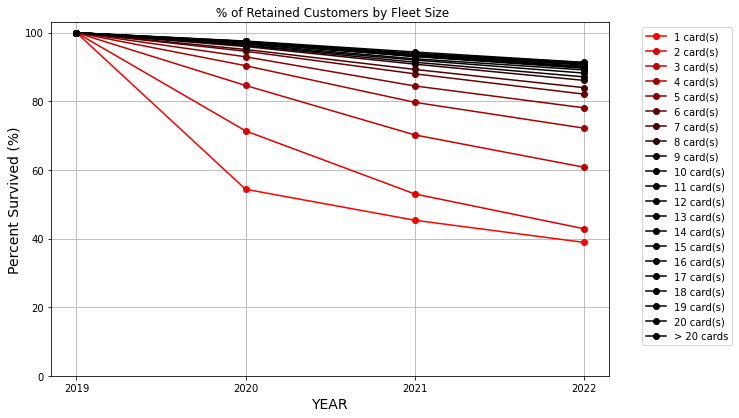

In [14]:
def rgb_to_hex(rgb):
    return '%02x%02x%02x' % rgb

fig, ax2 = plt.subplots(figsize=(10,6.5))

color_step_size = int(255 / len(_fleet_size))
color_step_size = 30

current_color_step_size = 255
for i in range(len(_fleet_size)):

    color = "#" + rgb_to_hex((current_color_step_size,0,0))
    current_color_step_size -= color_step_size
    if current_color_step_size<=0:
        current_color_step_size = 0

    fleet_size = _fleet_size[i]
    observed_avg_retention_rate = _observed_avg_retention_rate[i]
    expected_tenure = _expected_tenure[i]
    revenue_year = _revenue_year[i]
    observed_customer_percent = _observed_customer_percent[i]
    chart_forecast_year = _chart_forecast_year[i]
    chart_forecast_from_first = _chart_forecast_from_first[i]

    plt.plot(revenue_year,observed_customer_percent, marker='o', color = color)
    #plt.plot(chart_forecast_year,chart_forecast_from_first, marker='o', c='black', linestyle='dashed')

ax2.set_ylim(ymin=0, ymax=103)
ax2.set_xlabel('YEAR', fontsize=14)
ax2.set_ylabel('Percent Survived (%)', fontsize=14)
ax2.grid()
plt.title(' % of Retained Customers by Fleet Size')
plt.legend(_fleet_size, bbox_to_anchor=(1.05,1.0), loc='upper left')
plt.show()

In [15]:
_color_list = []
step_size=30
for i in range(21):
    red_val = 255-i*step_size
    if red_val<0:
        red_val=0
    _color_list.append("#" + rgb_to_hex((red_val,0,0)))
print(_color_list)

['#ff0000', '#e10000', '#c30000', '#a50000', '#870000', '#690000', '#4b0000', '#2d0000', '#0f0000', '#000000', '#000000', '#000000', '#000000', '#000000', '#000000', '#000000', '#000000', '#000000', '#000000', '#000000', '#000000']


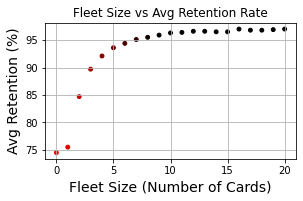

In [16]:
_fleet_size_num = []
for i in range(len(_fleet_size)):
    _fleet_size_num.append(i)
_fleet_size_num

_observed_avg_retention_rate_percent = []
for avg_retention_rate in _observed_avg_retention_rate:
    _observed_avg_retention_rate_percent.append(100*round(avg_retention_rate,3))

fig, ax2 = plt.subplots(figsize=(4.5,2.5))
ax2.set_xlabel('Fleet Size (Number of Cards)', fontsize=14)
ax2.set_ylabel('Avg Retention (%)', fontsize=14)
ax2.grid()

plt.scatter(_fleet_size_num, _observed_avg_retention_rate_percent, s=15, c=_color_list)
plt.title('Fleet Size vs Avg Retention Rate')
plt.show()

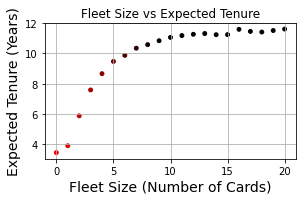

In [17]:
fig, ax2 = plt.subplots(figsize=(4.5,2.5))
ax2.set_xlabel('Fleet Size (Number of Cards)', fontsize=14)
ax2.set_ylabel('Expected Tenure (Years)', fontsize=14)
ax2.grid()

plt.scatter(_fleet_size_num, _expected_tenure, s=15,c=_color_list)
plt.title('Fleet Size vs Expected Tenure')
plt.show()

In [18]:
df_retention_rates_by_fleet_size = pd.DataFrame(_fleet_size, columns=['Fleet Size'])
df_retention_rates_by_fleet_size['Expected Tenure'] = _expected_tenure
df_retention_rates_by_fleet_size['Observed Retention Rate'] = _observed_avg_retention_rate
df_retention_rates_by_fleet_size.head(25)

,Fleet Size,Expected Tenure,Observed Retention Rate
0,1 card(s),3.463624,0.745156
1,2 card(s),3.915200,0.755092
2,3 card(s),5.888349,0.847355
3,4 card(s),7.594742,0.897190
4,5 card(s),8.667169,0.921081
5,6 card(s),9.472511,0.936459
6,7 card(s),9.874134,0.943584
7,8 card(s),10.346954,0.951446
8,9 card(s),10.579534,0.955201
9,10 card(s),10.835319,0.959202


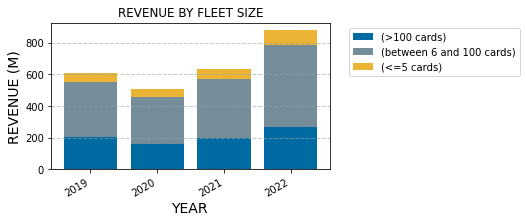

In [19]:
df_revenue_by_year = df_j.groupby(['REVENUE_YEAR','FLEET_SIZE_GROUP']).REVENUE_AMOUNT_USD.sum().reset_index()

colors = ['#006BA2','#758D99','#EBB434']
labels = ['(>100 cards)','(between 6 and 100 cards)','(<=5 cards)']

fig, ax = plt.subplots(1, figsize=(5,3))
divider = 1000000

max_value = 0
bottom = len(df_revenue_by_year.REVENUE_YEAR.unique()) * [0]
for idx,s in enumerate(labels):

    dim1 = list(map(str,df_revenue_by_year[df_revenue_by_year.FLEET_SIZE_GROUP==s].REVENUE_YEAR))
    data1 = df_revenue_by_year[df_revenue_by_year.FLEET_SIZE_GROUP==s].REVENUE_AMOUNT_USD/divider

    ax.bar(dim1, data1, bottom=bottom, color=colors[idx])
    bottom = [sum(i) for i in zip(data1, bottom )]

ax.set_xlabel('YEAR', fontsize=14)
ax.set_ylabel('REVENUE (M)', fontsize=14)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax.grid(color='#95a5a6', linestyle='--', linewidth=1, axis='y', alpha=0.6)
fig.autofmt_xdate()
plt.title('REVENUE BY FLEET SIZE')
plt.legend(labels, bbox_to_anchor=(1.05,1.0), loc='upper left')
plt.show()

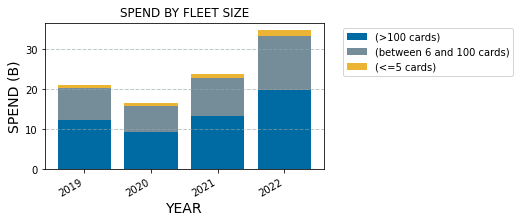

In [20]:
df_spend_by_year = df_j.groupby(['REVENUE_YEAR','FLEET_SIZE_GROUP']).GROSS_SPEND_AMOUNT.sum().reset_index()

colors = ['#006BA2','#758D99','#EBB434']
labels = ['(>100 cards)','(between 6 and 100 cards)','(<=5 cards)']

fig, ax = plt.subplots(1, figsize=(5,3))

divider = 1000000000

max_value = 0
bottom = len(df_spend_by_year.REVENUE_YEAR.unique()) * [0]
for idx,s in enumerate(labels):

    dim1 = list(map(str,df_spend_by_year[df_spend_by_year.FLEET_SIZE_GROUP==s].REVENUE_YEAR))
    data1 = df_spend_by_year[df_spend_by_year.FLEET_SIZE_GROUP==s].GROSS_SPEND_AMOUNT/divider

    ax.bar(dim1, data1, bottom=bottom, color=colors[idx])
    bottom = [sum(i) for i in zip(data1, bottom )]

ax.set_xlabel('YEAR', fontsize=14)
ax.set_ylabel('SPEND (B)', fontsize=14)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax.grid(color='#95a5a6', linestyle='--', linewidth=1, axis='y', alpha=0.6)
fig.autofmt_xdate()
plt.title('SPEND BY FLEET SIZE')
plt.legend(labels, bbox_to_anchor=(1.05,1.0), loc='upper left')
plt.show()

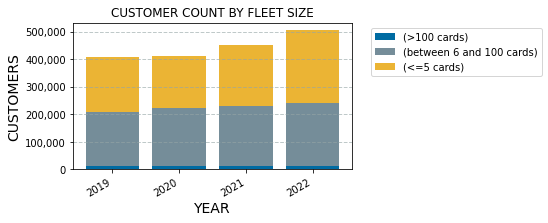

In [21]:
df_customer_by_year = df_j.groupby(['REVENUE_YEAR','FLEET_SIZE_GROUP']).CUSTOMER_ID.nunique().reset_index()
df_customer_by_year.columns = ['REVENUE_YEAR', 'FLEET_SIZE_GROUP', 'CUSTOMER_COUNT']

colors = ['#006BA2','#758D99','#EBB434']
labels = ['(>100 cards)','(between 6 and 100 cards)','(<=5 cards)']

fig, ax = plt.subplots(1, figsize=(5,3))

max_value = 0
bottom = len(df_customer_by_year.REVENUE_YEAR.unique()) * [0]
for idx,s in enumerate(labels):

    dim1 = list(map(str,df_customer_by_year[df_customer_by_year.FLEET_SIZE_GROUP==s].REVENUE_YEAR))
    data1 = df_customer_by_year[df_customer_by_year.FLEET_SIZE_GROUP==s].CUSTOMER_COUNT

    ax.bar(dim1, data1, bottom=bottom, color=colors[idx])
    bottom = [sum(i) for i in zip(data1, bottom )]

ax.set_xlabel('YEAR', fontsize=14)
ax.set_ylabel('CUSTOMERS', fontsize=14)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax.grid(color='#95a5a6', linestyle='--', linewidth=1, axis='y', alpha=0.6)
fig.autofmt_xdate()
plt.title('CUSTOMER COUNT BY FLEET SIZE')
plt.legend(labels, bbox_to_anchor=(1.05,1.0), loc='upper left')
plt.show()

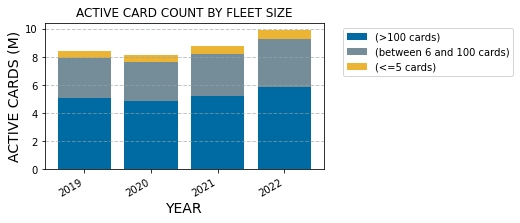

In [22]:
df_active_cards_by_year = df_j.groupby(['REVENUE_YEAR','FLEET_SIZE_GROUP']).ACTIVE_CARD_COUNT.sum().reset_index()

colors = ['#006BA2','#758D99','#EBB434']
labels = ['(>100 cards)','(between 6 and 100 cards)','(<=5 cards)']

divider = 1000000
fig, ax = plt.subplots(1, figsize=(5,3))

max_value = 0
bottom = len(df_active_cards_by_year.REVENUE_YEAR.unique()) * [0]
for idx,s in enumerate(labels):

    dim1 = list(map(str,df_active_cards_by_year[df_active_cards_by_year.FLEET_SIZE_GROUP==s].REVENUE_YEAR))
    data1 = df_active_cards_by_year[df_active_cards_by_year.FLEET_SIZE_GROUP==s].ACTIVE_CARD_COUNT/divider

    ax.bar(dim1, data1, bottom=bottom, color=colors[idx])
    bottom = [sum(i) for i in zip(data1, bottom )]

ax.set_xlabel('YEAR', fontsize=14)
ax.set_ylabel('ACTIVE CARDS (M)', fontsize=14)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax.grid(color='#95a5a6', linestyle='--', linewidth=1, axis='y', alpha=0.6)
fig.autofmt_xdate()
plt.title('ACTIVE CARD COUNT BY FLEET SIZE')
plt.legend(labels, bbox_to_anchor=(1.05,1.0), loc='upper left')
plt.show()

In [23]:
print(len(df_revenue_by_year))
print(len(df_active_cards_by_year))

df_revenue_per_card_by_year = pd.merge(df_revenue_by_year,df_active_cards_by_year)
print(len(df_revenue_per_card_by_year))

df_revenue_per_card_by_year['REVENUE_PER_CARD'] = df_revenue_per_card_by_year.REVENUE_AMOUNT_USD / df_revenue_per_card_by_year.ACTIVE_CARD_COUNT
df_revenue_per_card_by_year.head(100)

12
12
12


,REVENUE_YEAR,FLEET_SIZE_GROUP,REVENUE_AMOUNT_USD,ACTIVE_CARD_COUNT,REVENUE_PER_CARD
0,2019,(<=5 cards),5.682940e+07,517596.0,109.794896
1,2019,(>100 cards),2.043435e+08,5114860.0,39.950956
2,2019,(between 6 and 100 cards),3.507134e+08,2782073.0,126.061915
3,2020,(<=5 cards),4.892064e+07,480123.0,101.891891
4,2020,(>100 cards),1.613186e+08,4876994.0,33.077465
5,2020,(between 6 and 100 cards),2.986978e+08,2751143.0,108.572255
6,2021,(<=5 cards),6.461378e+07,569817.0,113.393906
7,2021,(>100 cards),2.005151e+08,5236128.0,38.294536
8,2021,(between 6 and 100 cards),3.680194e+08,2985727.0,123.259550
9,2022,(<=5 cards),9.994449e+07,694272.0,143.955816


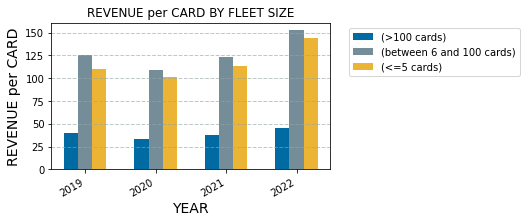

In [24]:
colors = ['#006BA2','#758D99','#EBB434']
labels = ['(>100 cards)','(between 6 and 100 cards)','(<=5 cards)']

fig, ax = plt.subplots(1, figsize=(5,3))

bar_width = 0.2
max_value = 0

x_axis = np.arange(len(df_revenue_per_card_by_year[df_revenue_per_card_by_year.FLEET_SIZE_GROUP==s]))

for idx,s in enumerate(labels):

    dim1 = list(map(str,df_revenue_per_card_by_year[df_revenue_per_card_by_year.FLEET_SIZE_GROUP==s].REVENUE_YEAR))
    data1 = df_revenue_per_card_by_year[df_revenue_per_card_by_year.FLEET_SIZE_GROUP==s].REVENUE_PER_CARD
    if idx==0:
        ax.bar(x_axis-0.2, data1, color=colors[idx], width=bar_width)

    if idx==1:
        ax.bar(x_axis, data1, color=colors[idx], width=bar_width)

    if idx==2:
        ax.bar(x_axis+0.2, data1, color=colors[idx], width=bar_width)


ax.set_xlabel('YEAR', fontsize=14)
ax.set_ylabel('REVENUE per CARD', fontsize=14)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax.grid(color='#95a5a6', linestyle='--', linewidth=1, axis='y', alpha=0.6)
fig.autofmt_xdate()
plt.title('REVENUE per CARD BY FLEET SIZE')
plt.legend(labels, bbox_to_anchor=(1.05,1.0), loc='upper left')
plt.xticks(x_axis, dim1)
plt.show()

In [25]:
df_revenue_per_card_by_year.groupby(['FLEET_SIZE_GROUP']).REVENUE_PER_CARD.mean().reset_index()

,FLEET_SIZE_GROUP,REVENUE_PER_CARD
0,(<=5 cards),117.259127
1,(>100 cards),39.112795
2,(between 6 and 100 cards),127.831863


In [0]:
# Compute recipe outputs
# TODO: Write here your actual code that computes the outputs
# NB: DSS supports several kinds of APIs for reading and writing data. Please see doc.

#TENURE_df = ... # Compute a Pandas dataframe to write into TENURE


# Write recipe outputs
#TENURE = dataiku.Dataset("TENURE")
#TENURE.write_with_schema(TENURE_df)